In [1]:
# ========= 0. Imports =========
import random, numpy as np, torch, re
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModel, get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import pandas as pd


d:\SRH\Github\Optimizing-Deep-Learning-Models-for-Text-Based-Emotion-Detection\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ========= 1. Reproducibility =========
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
# ========= 2. Device =========
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if device.type != "cuda":
    raise SystemExit("CUDA (GPU) not available.")

Using device: cuda


In [4]:
# ========= 3. Load Dataset Once =========
dataset = load_dataset("dair-ai/emotion", "split")
label_list = dataset["train"].features["label"].names
num_labels = len(label_list)

raw_train = list(zip(dataset["train"]["text"], dataset["train"]["label"]))
raw_val = list(zip(dataset["validation"]["text"], dataset["validation"]["label"]))
raw_test = list(zip(dataset["test"]["text"], dataset["test"]["label"]))

In [5]:
# ========= 4. Stats & Distribution =========

url_pattern = re.compile(r"https?://\S+")
mention_pattern = re.compile(r"@\w+")
hashtag_pattern = re.compile(r"#\w+")

def dataset_stats(data, name):
    texts = [t for t, _ in data]
    size = len(texts)
    urls = sum(bool(url_pattern.search(t)) for t in texts)
    mentions = sum(bool(mention_pattern.search(t)) for t in texts)
    hashtags = sum(bool(hashtag_pattern.search(t)) for t in texts)
    print(f"\n{name} Stats:")
    print(f" Total samples: {size}")
    print(f" {urls} contain URLs")
    print(f" {mentions} contain @mentions")
    print(f" {hashtags} contain #hashtags")

In [6]:
def plot_class_distribution(data, title):
    counts = Counter(label for _, label in data)
    labels = [label_list[i] for i in counts.keys()]
    values = list(counts.values())
    plt.figure(figsize=(8,5))
    sns.barplot(x=labels, y=values)
    plt.title(title)
    plt.ylabel("Count")
    plt.show()

In [7]:
def downsample(data):
    groups = {}
    for text, label in data:
        groups.setdefault(label, []).append((text, label))
    min_size = min(len(v) for v in groups.values())
    balanced = []
    for v in groups.values():
        balanced.extend(random.sample(v, min_size))
    random.shuffle(balanced)
    return balanced

In [8]:
def upsample(data):
    groups = {}
    for text, label in data:
        groups.setdefault(label, []).append((text, label))
    max_size = max(len(v) for v in groups.values())
    balanced = []
    for v in groups.values():
        balanced.extend(random.choices(v, k=max_size))
    random.shuffle(balanced)
    return balanced

In [9]:
# ========= 6. Tokenizer & Dataset =========
model_name = "boltuix/bert-emotion"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def find_optimal_length(data):
    lengths = [len(tokenizer.encode(t, add_special_tokens=True)) for t, _ in data]
    print("\nSequence Length Stats:")
    print(f" Max length: {np.max(lengths)}")
    print(f" 95th percentile: {np.percentile(lengths, 95)}")
    print(f" Mean length: {np.mean(lengths):.2f}")

def tokenize(texts, max_len=90):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len)

In [10]:
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.encodings["input_ids"][idx]),
            "attention_mask": torch.tensor(self.encodings["attention_mask"][idx]),
            "labels": torch.tensor(self.labels[idx]),
        }

In [11]:

# ========= 7. Model Components =========
class MeanPooling(nn.Module):
    def forward(self, last_hidden_state, attention_mask):
        mask_exp = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * mask_exp, 1)
        sum_mask = torch.clamp(mask_exp.sum(1), min=1e-9)
        return sum_embeddings / sum_mask

In [12]:
class DeepLMU(nn.Module):
    def __init__(self, hidden_size, memory_size=128, num_layers=6):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Linear(hidden_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
                nn.Dropout(0.2),
                nn.Linear(hidden_size, memory_size),
                nn.GELU(),
                nn.LayerNorm(memory_size),
                nn.Dropout(0.2),
                nn.Linear(memory_size, hidden_size),
                nn.GELU(),
                nn.LayerNorm(hidden_size),
            ) for _ in range(num_layers)
        ])
        self.self_attention = nn.MultiheadAttention(hidden_size, 8, batch_first=True)
        self.attention_norm = nn.LayerNorm(hidden_size)
    def forward(self, x):
        for layer in self.layers:
            x = x + layer(x)
        attn_out, _ = self.self_attention(x, x, x)
        return self.attention_norm(x + attn_out)

In [13]:
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.lmu = DeepLMU(self.bert.config.hidden_size)
        self.pooler = MeanPooling()
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.bert.config.hidden_size, num_labels)
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        hidden = self.lmu(outputs.last_hidden_state)
        pooled = self.pooler(hidden, attention_mask)
        return self.classifier(self.dropout(pooled))

In [14]:
# ========= 8. Training Pipeline =========
def pipeline(train_data, val_data, test_data, name, epochs=100, patience=10):
    print(f"\nRunning Pipeline: {name}")
    dataset_stats(train_data, f"{name}")
    plot_class_distribution(train_data, f"{name} Train Distribution")
    plot_class_distribution(val_data, f"{name} Val Distribution")
    plot_class_distribution(test_data, f"{name} Test Distribution")
    
    # Find token length
    find_optimal_length(train_data)
    find_optimal_length(val_data)
    find_optimal_length(test_data)
    # Prepare encodings
    train_texts, train_labels = zip(*train_data)
    val_texts, val_labels = zip(*val_data)
    test_texts, test_labels = zip(*test_data)

    train_enc = tokenize(train_texts)
    val_enc = tokenize(val_texts)
    test_enc = tokenize(test_texts)

    train_dataset = EmotionDataset(train_enc, list(train_labels))
    val_dataset = EmotionDataset(val_enc, list(val_labels))
    test_dataset = EmotionDataset(test_enc, list(test_labels))

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = EmotionClassifier(model_name, num_labels).to(device)
    class_weights = compute_class_weight("balanced", classes=np.unique(train_labels), y=train_labels)
    criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0,
                               num_training_steps=len(train_loader)*epochs)

    def evaluate(loader):
        model.eval()
        loss_total, preds, labels = 0, [], []
        with torch.no_grad():
            for batch in loader:
                ids, mask, targets = batch["input_ids"].to(device), batch["attention_mask"].to(device), batch["labels"].to(device)
                out = model(ids, mask)
                loss = criterion(out, targets)
                loss_total += loss.item()
                preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                labels.extend(targets.cpu().numpy())
        return loss_total/len(loader), accuracy_score(labels, preds), preds, labels


    # Training with Early Stopping
    best_acc, best_epoch = 0, 0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}
    for epoch in range(epochs):
        model.train()
        total_loss, preds_all, labels_all = 0, [], []
        for batch in tqdm(train_loader, desc=f"{name} Epoch {epoch+1}"):
            input_ids, mask, targets = (
                batch["input_ids"].to(device),
                batch["attention_mask"].to(device),
                batch["labels"].to(device),
            )
            optimizer.zero_grad()
            out = model(input_ids, mask)
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            total_loss += loss.item()
            preds_all.extend(torch.argmax(out, dim=1).cpu().numpy())
            labels_all.extend(targets.cpu().numpy())

        train_acc = accuracy_score(labels_all, preds_all)
        val_loss, val_acc, _, _ = evaluate(val_loader)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(total_loss / len(train_loader))
        history["val_loss"].append(val_loss)

        print(f"{name} Epoch {epoch+1}: Train {train_acc:.4f}, Val {val_acc:.4f}")
        if val_acc > best_acc:
            best_acc, best_epoch = val_acc, epoch
            torch.save(model.state_dict(), f"{name}_best.pt")
        elif epoch - best_epoch >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best Val Acc: {best_acc:.4f}")
            break

    # Plot Curves
    plt.figure(figsize=(10,5))
    plt.plot(history["train_acc"], label="Train Acc")
    plt.plot(history["val_acc"], label="Val Acc")
    plt.legend(); plt.title(f"{name} Accuracy"); plt.show()

    plt.figure(figsize=(10,5))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["val_loss"], label="Val Loss")
    plt.legend(); plt.title(f"{name} Loss"); plt.show()

    # Test
    model.load_state_dict(torch.load(f"{name}_best.pt"))
    _, test_acc, preds, labels = evaluate(test_loader)
    print(f"\n{name} Test Accuracy: {test_acc:.4f}")
    print(classification_report(labels, preds, target_names=label_list))

    cm = confusion_matrix(labels, preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_list, yticklabels=label_list)
    plt.title(f"{name} Confusion Matrix"); plt.show()



Running Pipeline: Raw

Raw Stats:
 Total samples: 16000
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags


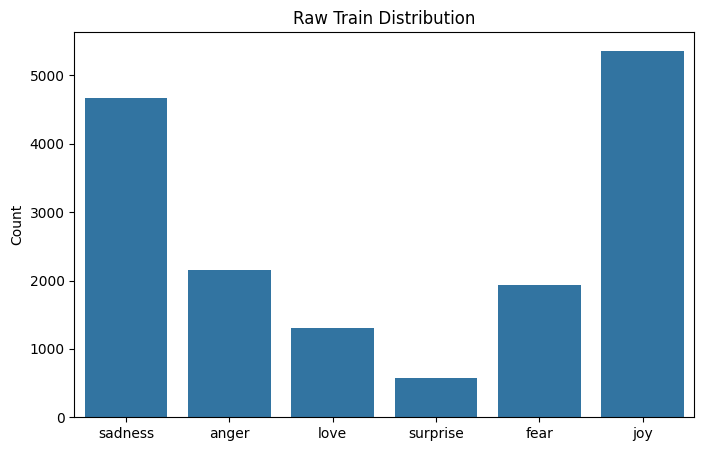

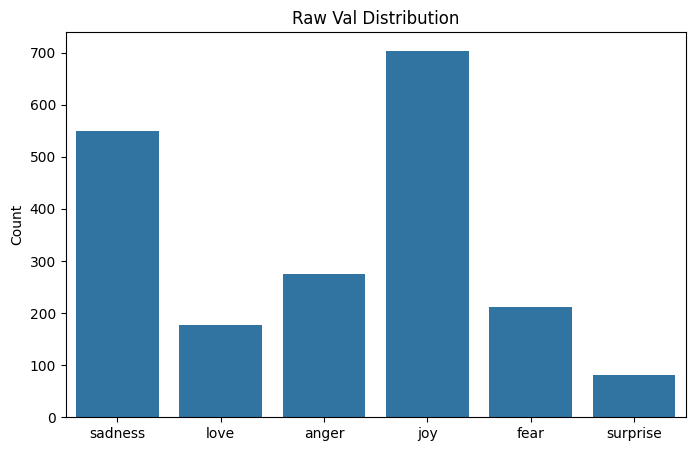

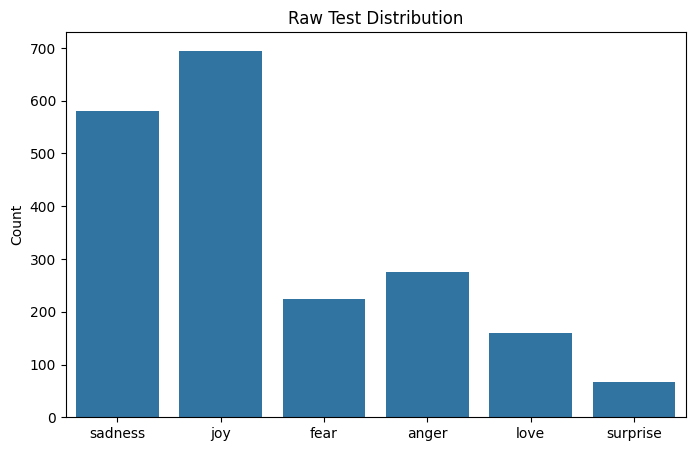


Sequence Length Stats:
 Max length: 87
 95th percentile: 45.0
 Mean length: 22.26

Sequence Length Stats:
 Max length: 69
 95th percentile: 44.0
 Mean length: 21.90

Sequence Length Stats:
 Max length: 66
 95th percentile: 45.0
 Mean length: 22.21


Raw Epoch 1: 100%|██████████| 500/500 [00:20<00:00, 24.74it/s]


Raw Epoch 1: Train 0.9247, Val 0.9490


Raw Epoch 2: 100%|██████████| 500/500 [00:20<00:00, 24.19it/s]


Raw Epoch 2: Train 0.9473, Val 0.9525


Raw Epoch 3: 100%|██████████| 500/500 [00:19<00:00, 26.15it/s]


Raw Epoch 3: Train 0.9521, Val 0.9515


Raw Epoch 4: 100%|██████████| 500/500 [00:18<00:00, 26.37it/s]


Raw Epoch 4: Train 0.9532, Val 0.9545


Raw Epoch 5: 100%|██████████| 500/500 [00:18<00:00, 27.34it/s]


Raw Epoch 5: Train 0.9602, Val 0.9460


Raw Epoch 6: 100%|██████████| 500/500 [00:18<00:00, 26.46it/s]


Raw Epoch 6: Train 0.9636, Val 0.9565


Raw Epoch 7: 100%|██████████| 500/500 [00:18<00:00, 26.41it/s]


Raw Epoch 7: Train 0.9679, Val 0.9490


Raw Epoch 8: 100%|██████████| 500/500 [00:18<00:00, 27.08it/s]


Raw Epoch 8: Train 0.9689, Val 0.9565


Raw Epoch 9: 100%|██████████| 500/500 [00:18<00:00, 26.86it/s]


Raw Epoch 9: Train 0.9732, Val 0.9580


Raw Epoch 10: 100%|██████████| 500/500 [00:20<00:00, 23.95it/s]


Raw Epoch 10: Train 0.9748, Val 0.9555


Raw Epoch 11: 100%|██████████| 500/500 [00:18<00:00, 27.16it/s]


Raw Epoch 11: Train 0.9784, Val 0.9485


Raw Epoch 12: 100%|██████████| 500/500 [00:18<00:00, 27.31it/s]


Raw Epoch 12: Train 0.9813, Val 0.9535


Raw Epoch 13: 100%|██████████| 500/500 [00:18<00:00, 27.10it/s]


Raw Epoch 13: Train 0.9798, Val 0.9540


Raw Epoch 14: 100%|██████████| 500/500 [00:18<00:00, 26.95it/s]


Raw Epoch 14: Train 0.9819, Val 0.9540


Raw Epoch 15: 100%|██████████| 500/500 [00:18<00:00, 26.73it/s]


Raw Epoch 15: Train 0.9828, Val 0.9505


Raw Epoch 16: 100%|██████████| 500/500 [00:19<00:00, 25.64it/s]


Raw Epoch 16: Train 0.9839, Val 0.9560


Raw Epoch 17: 100%|██████████| 500/500 [00:17<00:00, 27.96it/s]


Raw Epoch 17: Train 0.9871, Val 0.9540


Raw Epoch 18: 100%|██████████| 500/500 [00:18<00:00, 26.94it/s]


Raw Epoch 18: Train 0.9887, Val 0.9515


Raw Epoch 19: 100%|██████████| 500/500 [00:19<00:00, 25.39it/s]


Raw Epoch 19: Train 0.9878, Val 0.9515
Early stopping at epoch 19. Best Val Acc: 0.9580


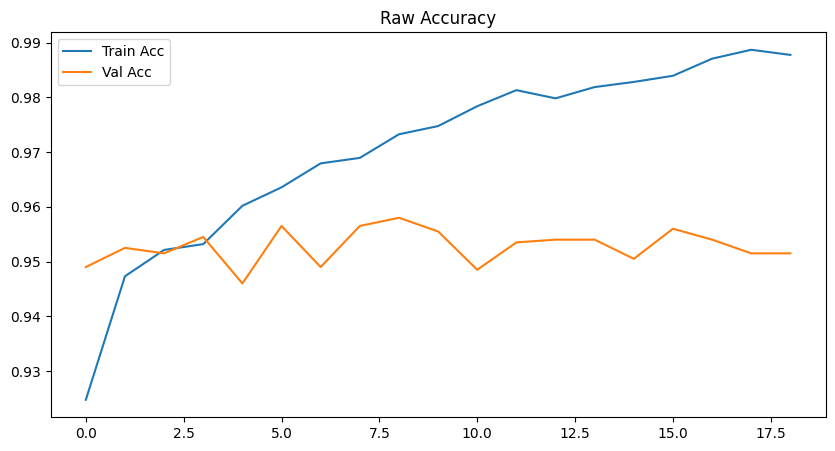

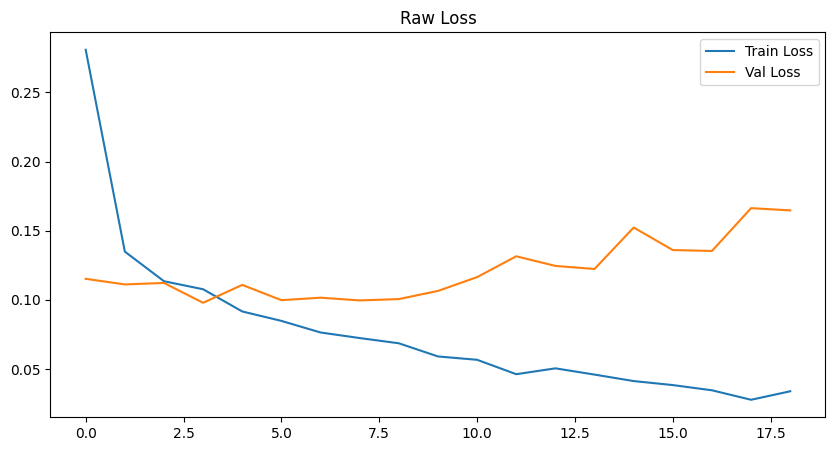


Raw Test Accuracy: 0.9440
              precision    recall  f1-score   support

     sadness       0.99      0.96      0.97       581
         joy       0.99      0.93      0.96       695
        love       0.78      0.95      0.86       159
       anger       0.93      0.97      0.95       275
        fear       0.94      0.91      0.93       224
    surprise       0.73      0.92      0.82        66

    accuracy                           0.94      2000
   macro avg       0.89      0.94      0.91      2000
weighted avg       0.95      0.94      0.95      2000



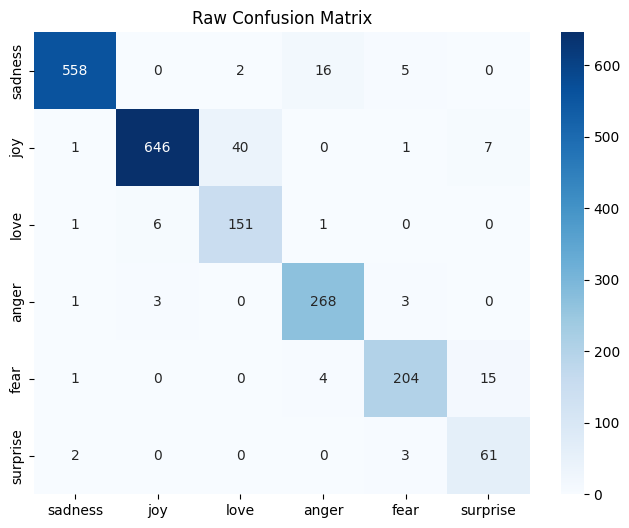

In [15]:
pipeline(raw_train, raw_val, raw_test, "Raw")


Running Pipeline: Downsampled

Downsampled Stats:
 Total samples: 3432
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags


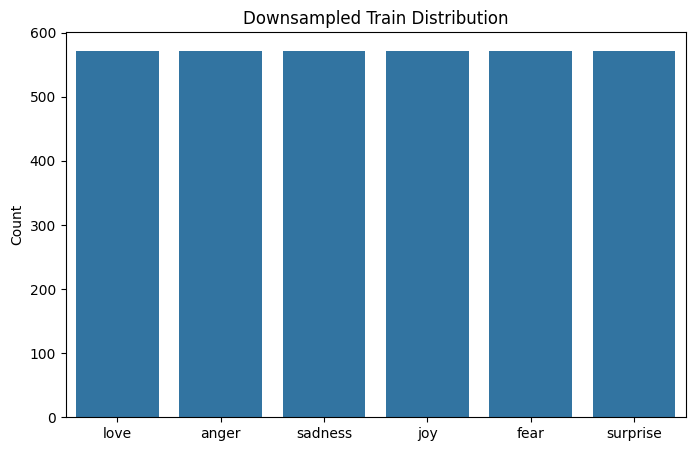

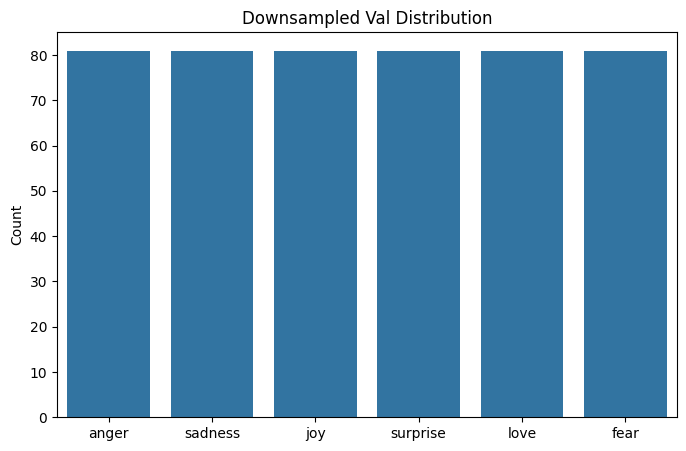

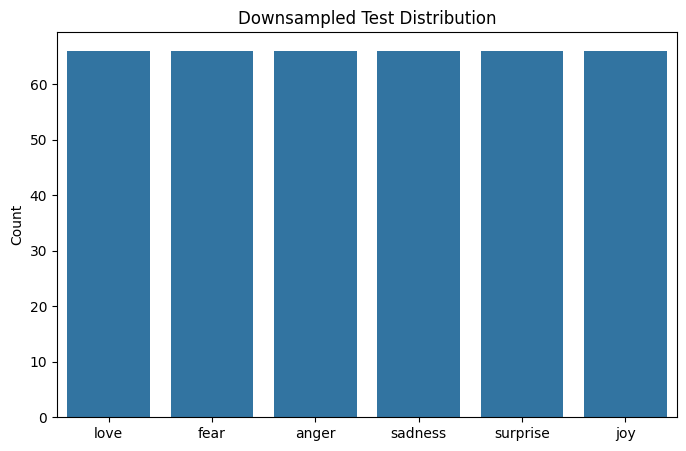


Sequence Length Stats:
 Max length: 87
 95th percentile: 44.0
 Mean length: 22.58

Sequence Length Stats:
 Max length: 63
 95th percentile: 43.0
 Mean length: 22.57

Sequence Length Stats:
 Max length: 66
 95th percentile: 47.25
 Mean length: 22.39


Downsampled Epoch 1: 100%|██████████| 108/108 [00:12<00:00,  8.41it/s]


Downsampled Epoch 1: Train 0.8802, Val 0.9403


Downsampled Epoch 2: 100%|██████████| 108/108 [00:12<00:00,  8.78it/s]


Downsampled Epoch 2: Train 0.9467, Val 0.9465


Downsampled Epoch 3: 100%|██████████| 108/108 [00:12<00:00,  8.64it/s]


Downsampled Epoch 3: Train 0.9522, Val 0.9465


Downsampled Epoch 4: 100%|██████████| 108/108 [00:12<00:00,  8.36it/s]


Downsampled Epoch 4: Train 0.9554, Val 0.9486


Downsampled Epoch 5: 100%|██████████| 108/108 [00:12<00:00,  9.00it/s]


Downsampled Epoch 5: Train 0.9627, Val 0.9486


Downsampled Epoch 6: 100%|██████████| 108/108 [00:11<00:00,  9.61it/s]


Downsampled Epoch 6: Train 0.9665, Val 0.9424


Downsampled Epoch 7: 100%|██████████| 108/108 [00:03<00:00, 27.79it/s]


Downsampled Epoch 7: Train 0.9662, Val 0.9506


Downsampled Epoch 8: 100%|██████████| 108/108 [00:04<00:00, 26.54it/s]


Downsampled Epoch 8: Train 0.9691, Val 0.9424


Downsampled Epoch 9: 100%|██████████| 108/108 [00:04<00:00, 26.01it/s]


Downsampled Epoch 9: Train 0.9694, Val 0.9362


Downsampled Epoch 10: 100%|██████████| 108/108 [00:04<00:00, 26.43it/s]


Downsampled Epoch 10: Train 0.9779, Val 0.9465


Downsampled Epoch 11: 100%|██████████| 108/108 [00:04<00:00, 26.14it/s]


Downsampled Epoch 11: Train 0.9796, Val 0.9486


Downsampled Epoch 12: 100%|██████████| 108/108 [00:04<00:00, 26.10it/s]


Downsampled Epoch 12: Train 0.9828, Val 0.9444


Downsampled Epoch 13: 100%|██████████| 108/108 [00:04<00:00, 25.93it/s]


Downsampled Epoch 13: Train 0.9846, Val 0.9403


Downsampled Epoch 14: 100%|██████████| 108/108 [00:04<00:00, 26.06it/s]


Downsampled Epoch 14: Train 0.9822, Val 0.9486


Downsampled Epoch 15: 100%|██████████| 108/108 [00:04<00:00, 26.63it/s]


Downsampled Epoch 15: Train 0.9848, Val 0.9465


Downsampled Epoch 16: 100%|██████████| 108/108 [00:04<00:00, 26.65it/s]


Downsampled Epoch 16: Train 0.9875, Val 0.9403


Downsampled Epoch 17: 100%|██████████| 108/108 [00:04<00:00, 26.49it/s]


Downsampled Epoch 17: Train 0.9898, Val 0.9383
Early stopping at epoch 17. Best Val Acc: 0.9506


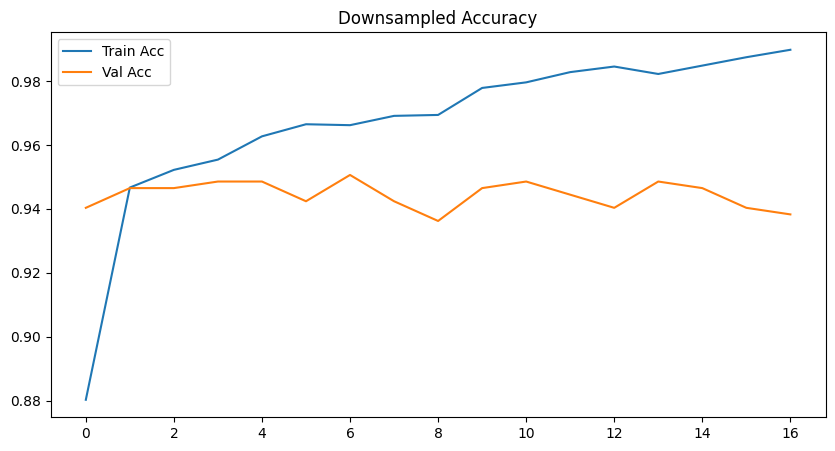

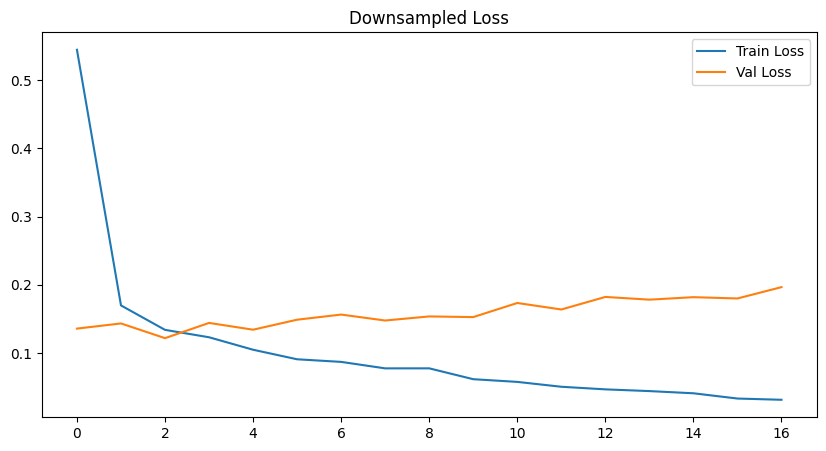


Downsampled Test Accuracy: 0.9520
              precision    recall  f1-score   support

     sadness       1.00      0.95      0.98        66
         joy       0.97      0.92      0.95        66
        love       0.94      0.95      0.95        66
       anger       0.93      0.98      0.96        66
        fear       0.95      0.91      0.93        66
    surprise       0.93      0.98      0.96        66

    accuracy                           0.95       396
   macro avg       0.95      0.95      0.95       396
weighted avg       0.95      0.95      0.95       396



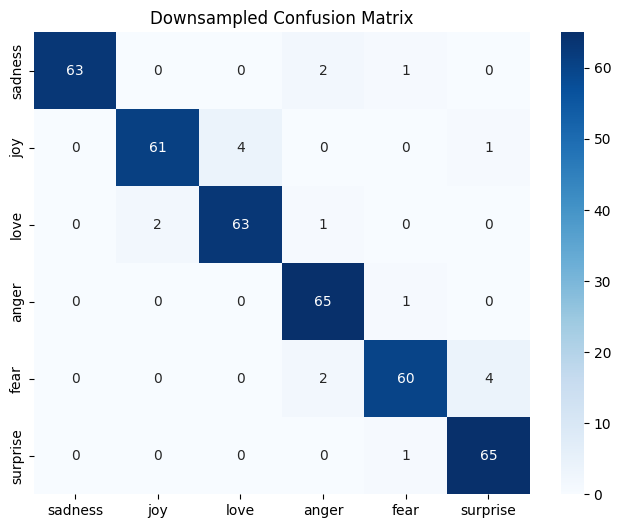

In [16]:
pipeline(downsample(raw_train), downsample(raw_val), downsample(raw_test), "Downsampled")


Running Pipeline: Upsampled

Upsampled Stats:
 Total samples: 32172
 0 contain URLs
 0 contain @mentions
 0 contain #hashtags


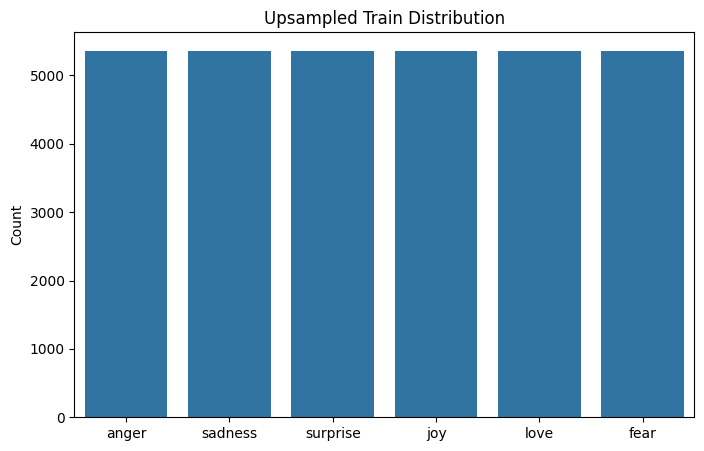

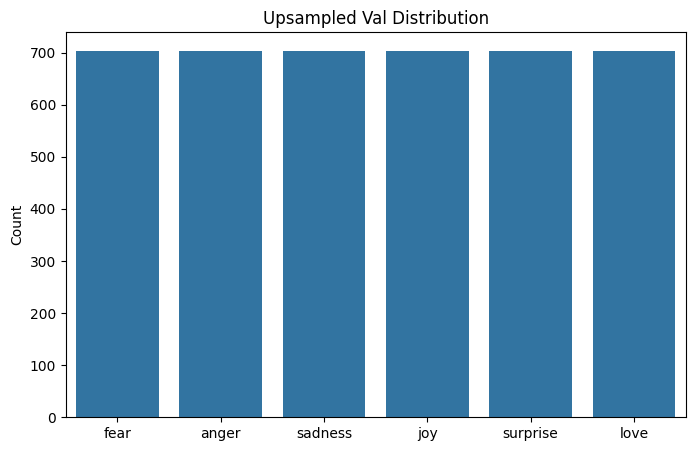

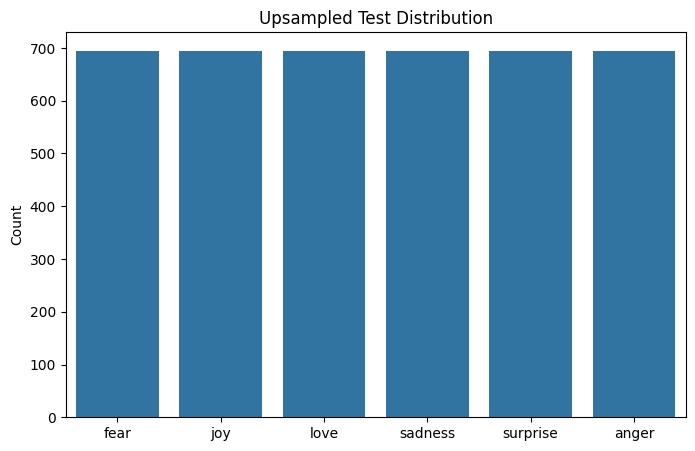


Sequence Length Stats:
 Max length: 87
 95th percentile: 45.0
 Mean length: 22.53

Sequence Length Stats:
 Max length: 66
 95th percentile: 43.0
 Mean length: 21.96

Sequence Length Stats:
 Max length: 66
 95th percentile: 45.0
 Mean length: 22.17


Upsampled Epoch 1: 100%|██████████| 1006/1006 [00:40<00:00, 24.95it/s]


Upsampled Epoch 1: Train 0.9374, Val 0.9600


Upsampled Epoch 2: 100%|██████████| 1006/1006 [00:38<00:00, 26.33it/s]


Upsampled Epoch 2: Train 0.9659, Val 0.9534


Upsampled Epoch 3: 100%|██████████| 1006/1006 [00:37<00:00, 27.10it/s]


Upsampled Epoch 3: Train 0.9748, Val 0.9536


Upsampled Epoch 4: 100%|██████████| 1006/1006 [01:14<00:00, 13.52it/s]


Upsampled Epoch 4: Train 0.9809, Val 0.9500


Upsampled Epoch 5: 100%|██████████| 1006/1006 [01:35<00:00, 10.51it/s]


Upsampled Epoch 5: Train 0.9860, Val 0.9460


Upsampled Epoch 6: 100%|██████████| 1006/1006 [01:43<00:00,  9.74it/s]


Upsampled Epoch 6: Train 0.9882, Val 0.9439


Upsampled Epoch 7: 100%|██████████| 1006/1006 [01:34<00:00, 10.70it/s]


Upsampled Epoch 7: Train 0.9906, Val 0.9482


Upsampled Epoch 8: 100%|██████████| 1006/1006 [01:31<00:00, 10.97it/s]


Upsampled Epoch 8: Train 0.9915, Val 0.9470


Upsampled Epoch 9: 100%|██████████| 1006/1006 [01:16<00:00, 13.17it/s]


Upsampled Epoch 9: Train 0.9929, Val 0.9555


Upsampled Epoch 10: 100%|██████████| 1006/1006 [01:28<00:00, 11.36it/s]


Upsampled Epoch 10: Train 0.9928, Val 0.9325


Upsampled Epoch 11: 100%|██████████| 1006/1006 [01:20<00:00, 12.47it/s]


Upsampled Epoch 11: Train 0.9944, Val 0.9316
Early stopping at epoch 11. Best Val Acc: 0.9600


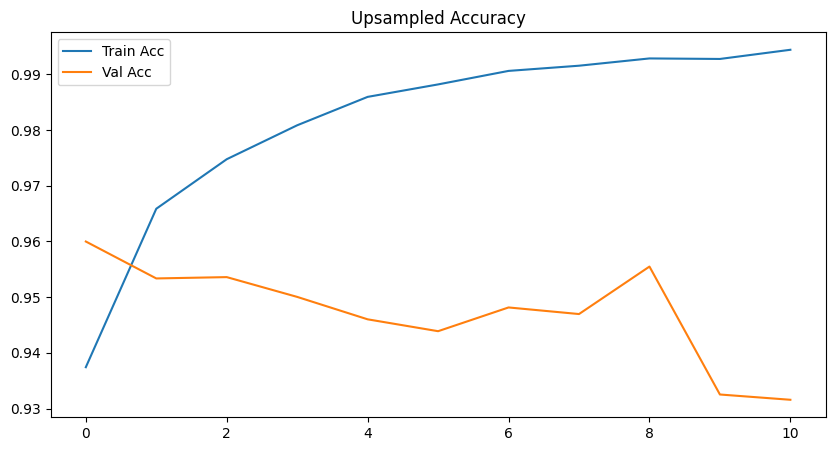

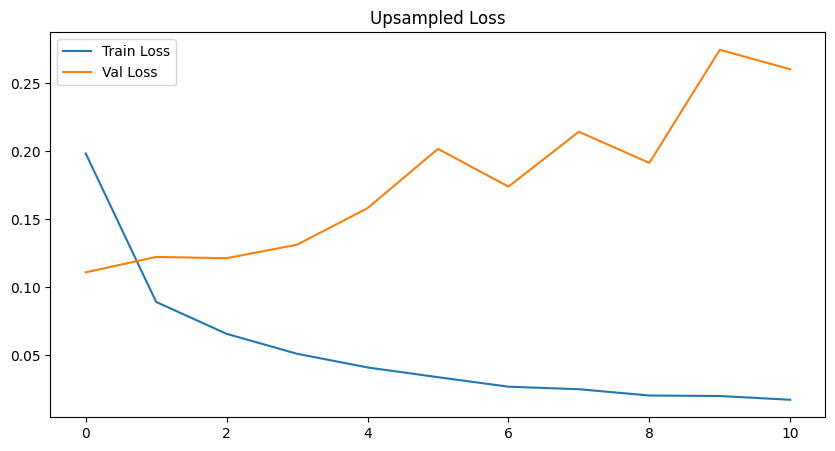


Upsampled Test Accuracy: 0.9592
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       695
         joy       0.99      0.94      0.96       695
        love       0.94      0.99      0.97       695
       anger       0.97      0.99      0.98       695
        fear       0.99      0.89      0.93       695
    surprise       0.91      0.99      0.95       695

    accuracy                           0.96      4170
   macro avg       0.96      0.96      0.96      4170
weighted avg       0.96      0.96      0.96      4170



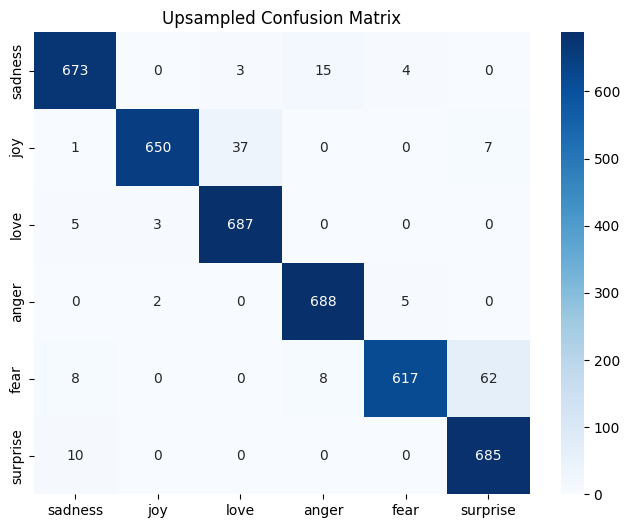

In [17]:
pipeline(upsample(raw_train), upsample(raw_val), upsample(raw_test), "Upsampled")
